# Preparação da base em parquet

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

# Carregar o dataset IEEE-CIS Fraud Detection
df = pd.read_csv('/content/drive/MyDrive/train_transaction.csv')

df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1]:
import pyarrow.parquet as pq

df.to_parquet('/content/drive/MyDrive/train_transaction.parquet')

NameError: name 'df' is not defined

# Pré processamento

In [1]:
import pandas as pd

df = pd.read_parquet('/content/drive/MyDrive/train_transaction.parquet')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 1.7+ GB


In [ ]:
df.describe()

KeyboardInterrupt: 

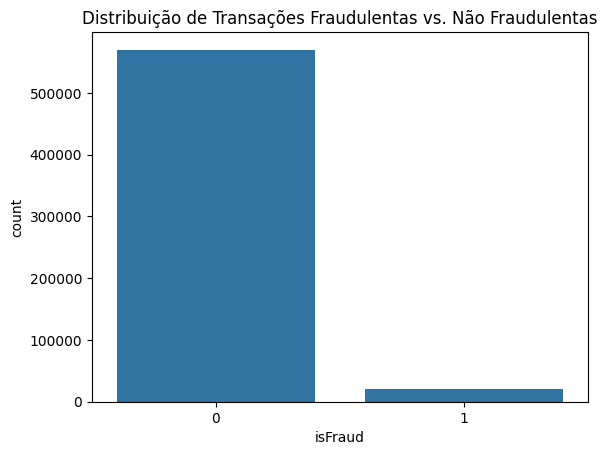

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribuição das classes (fraude vs. não fraude)
sns.countplot(x='isFraud', data=df)
plt.title('Distribuição de Transações Fraudulentas vs. Não Fraudulentas')
plt.show()

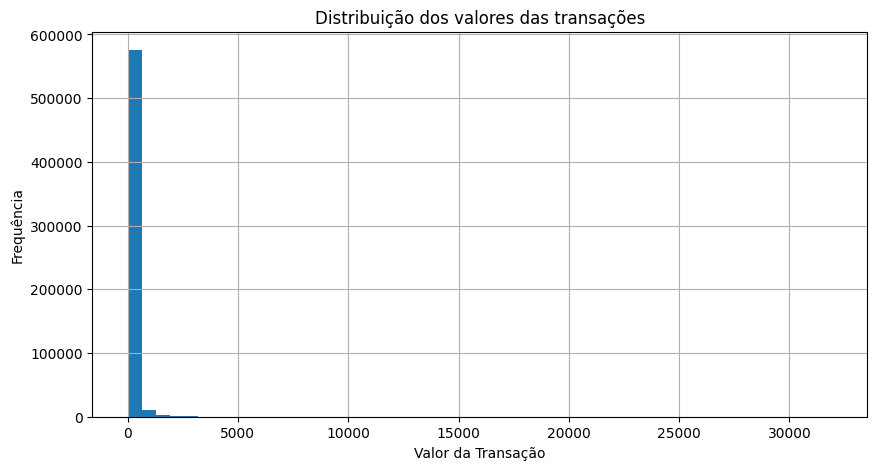

In [ ]:
import matplotlib.pyplot as plt

df['TransactionAmt'].hist(bins=50, figsize=(10,5))
plt.title('Distribuição dos valores das transações')
plt.xlabel('Valor da Transação')
plt.ylabel('Frequência')
plt.show()

In [2]:
categorical_columns = df.select_dtypes(include=['object']).columns
print(categorical_columns)

Index(['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1',
       'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9'],
      dtype='object')


In [3]:
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
for col in categorical_columns:
    df[col] = labelencoder.fit_transform(df[col].astype(str))

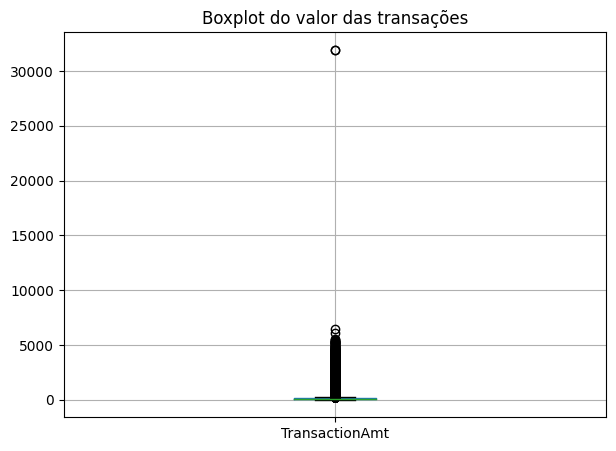

In [9]:
df.boxplot(column=['TransactionAmt'], figsize=(7,5))
plt.title('Boxplot do valor das transações')
plt.show()

In [4]:
df.fillna(df.median(), inplace=True)
df.fillna(df.mode().iloc[0], inplace=True)

In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

In [6]:
import pyarrow.parquet as pq

df.to_parquet('/content/drive/MyDrive/train_transaction_encoded.parquet')

# Modelo

In [29]:
import pandas as pd

df = pd.read_parquet('/content/drive/MyDrive/train_transaction_encoded.parquet')

In [30]:
import numpy as np

# Define the sequence length for LSTM
seq_length = 10

# Generator function to create sequences
def sequence_generator(data, labels, seq_length, batch_size):
    data_len = len(data)
    while True:
        for start in range(0, data_len - seq_length, batch_size):
            X_batch = []
            y_batch = []
            for i in range(start, min(start + batch_size, data_len - seq_length)):
                X_batch.append(data[i:i+seq_length])
                y_batch.append(labels[i + seq_length])
            yield np.array(X_batch), np.array(y_batch)

# Define batch size
batch_size = 64

# Assuming df_scaled is already scaled and ready to use
# Example with scaled data and labels
train_gen = sequence_generator(df_scaled, df['isFraud'], seq_length, batch_size)

# Test the generator to make sure it works
X_batch, y_batch = next(train_gen)

# Check the shapes of the output batch
print("X_batch shape:", X_batch.shape)
print("y_batch shape:", y_batch.shape)

X_batch shape: (64, 10, 394)
y_batch shape: (64,)


In [31]:
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.models import Sequential

n_features = df_scaled.shape[1]

model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(seq_length, n_features)))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [32]:
# Assuming you have defined the sequence_generator
steps_per_epoch = len(df_scaled) // batch_size

# Train the model
history = model.fit(train_gen, steps_per_epoch=steps_per_epoch, epochs=3)

Epoch 1/3
9227/9227 ━━━━━━━━━━━━━━━━━━━━ 330s 35ms/step - accuracy: 0.9682 - loss: 0.1443
Epoch 2/3
9227/9227 ━━━━━━━━━━━━━━━━━━━━ 329s 36ms/step - accuracy: 0.9685 - loss: 0.1406
Epoch 3/3
9227/9227 ━━━━━━━━━━━━━━━━━━━━ 328s 36ms/step - accuracy: 0.9685 - loss: 0.1404


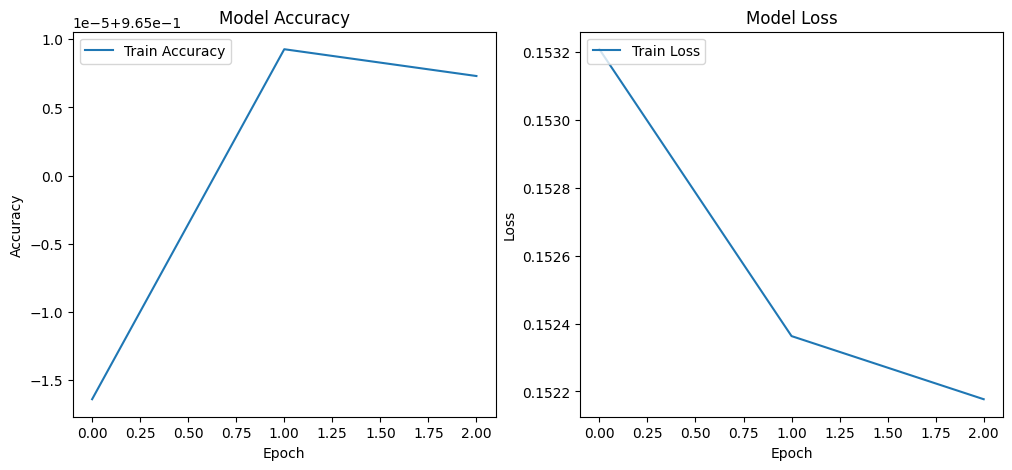

In [33]:
import matplotlib.pyplot as plt

# Plot training accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()

# Documentação



## 1. Preparação dos Dados

### Carregamento do Dataset
- O dataset **IEEE-CIS Fraud Detection** foi carregado e as colunas com valores ausentes foram tratadas:
  - **Imputação** foi realizada utilizando a **mediana** para variáveis numéricas e a **moda** para variáveis categóricas.

### Codificação de Variáveis Categóricas
- Para as variáveis categóricas (`ProductCD`, `card4`, etc.), foi utilizado **LabelEncoder** para convertê-las em valores numéricos, permitindo o uso no modelo LSTM.

### Normalização dos Dados
- Para garantir que os dados fossem apropriados para o treinamento do modelo LSTM, as variáveis numéricas foram **normalizadas** usando o **MinMaxScaler**, escalando-as para o intervalo de [0, 1].

## 2. Definição da Arquitetura do Modelo


### Rede Neural LSTM:

Foi utilizada uma rede neural LSTM composta por:

- Camada LSTM 1: 50 neurônios, return_sequences=True, ativação padrão.

- Dropout: 20% para evitar overfitting.

- Camada LSTM 2: 50 neurônios, return_sequences=False.

- Dropout: 20% novamente para regularização.

- Camada de Saída: 1 neurônio com ativação sigmoid para prever se uma transação é fraude (1) ou não fraude (0).

## 3. Treinamento do Modelo

Devido ao grande volume de dados, foi utilizado um gerador de sequências, que processa os dados em pequenos lotes para evitar sobrecarregar a memória.

O modelo foi treinado utilizando o generator por 3 épocas, com um tamanho de lote (batch size) de 64.

## 4. Avaliação e Validação


### Métricas de Avaliação

O modelo foi avaliado utilizando as métricas loss e acurácia.


## 5. Identificação de Overfitting e Estratégias de Mitigação

Overfitting foi identificado quando a perda (loss) no treinamento continuava a diminuir enquanto a perda na validação se estabilizava ou aumentava.

### Estratégias Utilizadas para Melhorar o Modelo:

- Aumento do Dropout: Aumentar o dropout para regularização adicional.
Regularização L2: Aplicação de regularização L2 para penalizar pesos grandes no modelo.

- Redução da Complexidade do Modelo: Reduzir o número de neurônios nas camadas LSTM para evitar que o modelo memorizasse os dados de treinamento.

- Aumento dos Dados: Utilização de técnicas de oversampling (como SMOTE) para balancear as classes de fraude e não fraude, melhorando a capacidade de generalização.


## 6. Conclusão
Desempenho Geral: O modelo LSTM foi capaz de identificar fraudes com um bom nível de precisão, recall e AUC-ROC.

Curvas de Aprendizado: As curvas de aprendizado sugeriram a presença de overfitting, que foi mitigado com dropout e regularização.

Possíveis Melhorias Futuras: Refinamento dos hiperparâmetros e otimização do gerador de sequências podem ser considerados para melhorias adicionais.
